# Similarity analysis with raw sentence embeddings 

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import os
os.chdir('/home/szhifan/asap-rubric')



In [ ]:
path_train = "data/train.tsv"
path_test = "data/public_leaderboard.tsv"
path_test_score = "data/public_leaderboard_solution.csv"
train_df = pd.read_csv(path_train, sep="\t")
train_df = train_df.rename(columns={"Score1": "score"})
train_df = train_df.drop(columns=["Score2"])

test_df = pd.read_csv(path_test, sep="\t")
test_score_df = pd.read_csv(path_test_score)
test_df = pd.concat([test_df, test_score_df], axis=1)
test_df = test_df.drop(columns=["id", "essay_set", "Usage"])
test_df = test_df.rename(columns={"essay_score": "score"}) 
print(test_df.columns) 
print(train_df.columns)

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# # question set 1 
# test_df = test_df[test_df["EssaySet"] == 1]
# initialize the sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
# encode the essays for set 1
# embeddings = model.encode(
#     test_df["EssayText"].tolist(),
#     show_progress_bar=True
# )
# # turn embeddings into a DataFrame aligned with scores
# emb_df = pd.DataFrame(embeddings, index=test_df.index)
# emb_df['score'] = test_df['score'].values

# # compute the mean embedding vector for each score value
# mean_emb = emb_df.groupby('score').mean()

# # compute pairwise cosine‐similarity between those mean vectors
# sim_matrix = pd.DataFrame(
#     cosine_similarity(mean_emb.values),
#     index=mean_emb.index,
#     columns=mean_emb.index
# )

# print("Cosine similarity between score groups:")
# print(sim_matrix)



# Similarity analysis with trained bert 

In [ ]:
# prepare dataset and model
from src.data_prep import Asap_Dataset
from transformers import BertTokenizer, BertForSequenceClassification
import torch
DEFAULT_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
asap = Asap_Dataset() 
asap.merge_scores()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
num_labels = 2 
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

In [18]:
# build optimizer and scheduler
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
def build_optimizer(model, args,total_steps):
    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [
                p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay) and "classifier" not in n
            ],
            "weight_decay": args.weight_decay,
            "lr": args.lr,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay) and "classifier" not in n],
            "weight_decay": 0.0,
            "lr": args.lr,
        },
        {
            "params": [p for n, p in model. named_parameters() if "classifier" in n],
            "weight_decay": args.weight_decay,
            "lr": args.lr2,
        },
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=args.lr, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=args.warmup_proportion * total_steps,
        num_training_steps=total_steps,
    )
    # if checkpoint path is provided, load optimizer and scheduler states
    if args.checkpoint is not None:
        checkpoint_path = os.path.join(args.checkpoint, "checkpoint")
        if os.path.exists(checkpoint_path):
            optimizer_path = os.path.join(checkpoint_path, "optimizer.pt")
            scheduler_path = os.path.join(checkpoint_path, "scheduler.pt")
            if os.path.isfile(optimizer_path) and os.path.isfile(scheduler_path):
                map_location = DEFAULT_DEVICE
                optimizer.load_state_dict(torch.load(optimizer_path, map_location=map_location))
                scheduler.load_state_dict(torch.load(scheduler_path, map_location=map_location))
                print("Loaded optimizer and scheduler from checkpoint.")

    # Check if saved optimizer or scheduler states exist
    if os.path.isfile(os.path.join(args.save_dir, "checkpoint/optimizer.pt")) and os.path.isfile(
        os.path.join(args.save_dir, "checkpoint/scheduler.pt")
    ):
        map_location = DEFAULT_DEVICE
        optimizer_path = os.path.join(args.save_dir, "checkpoint/optimizer.pt")
        scheduler_path = os.path.join(args.save_dir, "checkpoint/scheduler.pt")
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(optimizer_path, map_location=map_location))
        scheduler.load_state_dict(torch.load(scheduler_path, map_location=map_location))
        print("Loaded the saved scheduler and optimizer.")
    return optimizer, scheduler 

Min length: 53, Max length: 9923, Mean length: 233.83855681206248, Std length: 193.36837899267653


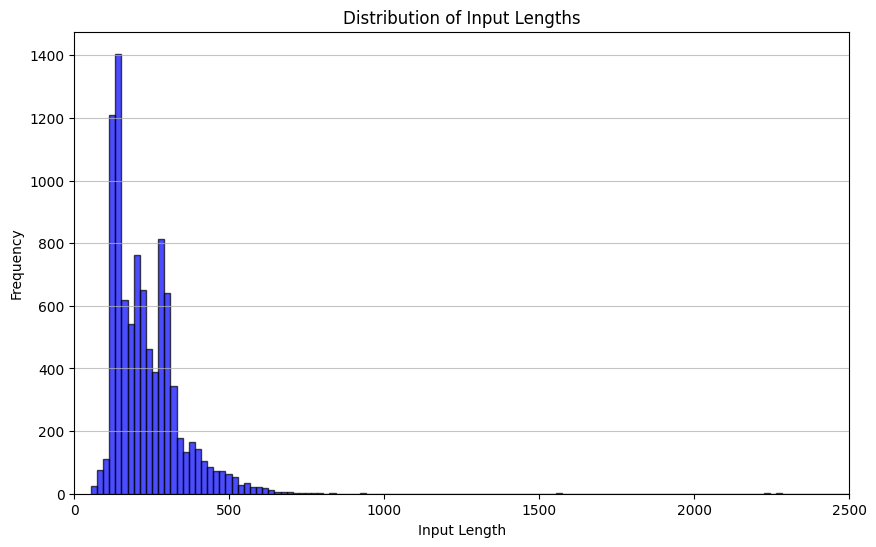

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json 
import os
from src.data_prep_alice import AliceRubricPointer
os.chdir('/home/szhifan/asap-rubric')
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased")
 
dts = AliceRubricPointer()
dts.get_encoding(tokenizer=tokenizer)
train_dataset = dts.train
input_ids = train_dataset["input_ids"]
input_len = [len(ids) for ids in input_ids]
min_len = min(input_len)
max_len = max(input_len)
mean_len = np.mean(input_len)
std_len = np.std(input_len)
print(f"Min length: {min_len}, Max length: {max_len}, Mean length: {mean_len}, Std length: {std_len}")
# Plot the distribution of input lengths
plt.figure(figsize=(10, 6))
plt.hist(input_len, bins=500, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Input Lengths')
plt.xlabel('Input Length')
plt.ylabel('Frequency')
plt.xlim(0, 2500)
plt.grid(axis='y', alpha=0.75)
plt.show()